#Library Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, LSTM, TimeDistributed, GlobalAveragePooling1D, GRU, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb
import os
import math
import matplotlib.pyplot as plotter

#Data Pre-Processing Steps (Same as Original Source Code)

In [ ]:
train_data = pd.read_csv('train.csv')
oil_data = pd.read_csv("oil.csv")
store_data = pd.read_csv("stores.csv")
transactions_data = pd.read_csv("transactions.csv")
holiday_events_data = pd.read_csv("holidays_events.csv")

In [ ]:
#PRE-PROCESSING TRAINING DATA

grouped_sales = train_data.pivot_table(index=['date', 'store_nbr'], columns='family', values='sales', aggfunc='sum')

grouped_sales.columns = [f'{column}_SALES' for column in grouped_sales.columns]

grouped_onpromotion = train_data.pivot_table(index=['date', 'store_nbr'], columns='family', values='onpromotion', aggfunc='sum')

grouped_onpromotion.columns = [f'{column}_ONPROMOTION' for column in grouped_onpromotion.columns]

cleaned_train_data = pd.concat([grouped_sales, grouped_onpromotion], axis=1).reset_index()

cleaned_train_data['date'] = pd.to_datetime(cleaned_train_data['date'])

#PRE-PROCESSING OIL DATA

oil_data['date'] = pd.to_datetime(oil_data['date'])

oil_data.set_index('date', inplace=True)

date_range = pd.date_range(start='2013-01-01', end='2017-08-31', freq='D')

oil_data = oil_data.reindex(date_range)

mean_oil_price_na = oil_data['dcoilwtico'].rolling(window=15, center=True, min_periods=1).mean()

oil_data['dcoilwtico'].fillna(mean_oil_price_na, inplace=True)

oil_data.reset_index(inplace=True)
oil_data.rename(columns={'index': 'date'}, inplace=True)

#MERGING OIL DATA COLUMNS

cleaned_train_data = pd.merge(cleaned_train_data, oil_data, on='date', how='left')

#MERGING STORE DATA COLUMNS

#Using left join to retain all the values from cleaned_train_data and just add the values from store_data to it
cleaned_train_data = pd.merge(cleaned_train_data, store_data, on='store_nbr', how='left')

#PRE-PROCESSING HOLIDAY EVENTS DATA

holiday_events_data['date'] = pd.to_datetime(holiday_events_data['date'])

#HOLIDAY EVENTS DATA PROCESSING

#Using the dates given in holiday events dataset and ignoring the number to then mark which days in the training dataset have holidays on them.

holiday_events_data['date'] = pd.to_datetime(holiday_events_data['date'])

holiday_events_data['month_day'] = holiday_events_data['date'].dt.strftime('%m-%d')
cleaned_train_data['month_day'] = cleaned_train_data['date'].dt.strftime('%m-%d')

holiday_month_days = set(holiday_events_data['month_day'])

cleaned_train_data['has_holiday'] = cleaned_train_data['month_day'].apply(lambda x: 1 if x in holiday_month_days else 0)

cleaned_train_data.drop('month_day', axis=1, inplace=True)

#Also using holiday dates to count the days until the next day in order to capture the correlation between the ramp up in sales to the occurence of the holiday. The holiday metric above isn't cutting it. Going to use a falg of three days, 1 week, and 2 weeks.

holiday_dates = cleaned_train_data[cleaned_train_data['has_holiday'] == 1]['date'].unique()

cleaned_train_data['three_days_before_holiday'] = 0
cleaned_train_data['one_week_before_holiday'] = 0
cleaned_train_data['two_weeks_before_holiday'] = 0
cleaned_train_data['three_weeks_before_holiday'] = 0

for holiday in holiday_dates:
    three_days_before = holiday - pd.Timedelta(days=3)
    one_week_before = holiday - pd.Timedelta(days=7)
    two_weeks_before = holiday - pd.Timedelta(days=14)
    three_weeks_before = holiday - pd.Timedelta(days=21)

    mask_three_days = (cleaned_train_data['date'] >= three_days_before) & (cleaned_train_data['date'] < holiday)
    cleaned_train_data.loc[mask_three_days, 'three_days_before_holiday'] = 1

    mask_one_week = (cleaned_train_data['date'] >= one_week_before) & (cleaned_train_data['date'] < holiday)
    cleaned_train_data.loc[mask_one_week, 'one_week_before_holiday'] = 1

    mask_two_weeks = (cleaned_train_data['date'] >= two_weeks_before) & (cleaned_train_data['date'] < one_week_before)
    cleaned_train_data.loc[mask_two_weeks, 'two_weeks_before_holiday'] = 1

    mask_three_weeks = (cleaned_train_data['date'] >= three_weeks_before) & (cleaned_train_data['date'] < two_weeks_before)
    cleaned_train_data.loc[mask_three_weeks, 'three_weeks_before_holiday'] = 1

cleaned_train_data.loc[cleaned_train_data['has_holiday'] == 1, ['three_days_before_holiday', 'one_week_before_holiday', 'two_weeks_before_holiday', 'three_weeks_before_holiday']] = 0


#CONVERTING DATE INTO SEPERATE FEATURES
cleaned_train_data['dow'] = cleaned_train_data['date'].dt.dayofweek
cleaned_train_data['month'] = cleaned_train_data['date'].dt.month
cleaned_train_data['num_date'] = cleaned_train_data['date'].dt.day
cleaned_train_data['year'] = cleaned_train_data['date'].dt.year

#USING LABEL ENCODING TO CONVERT STORE LOCATIONS AND HOLIDAY LOCATIONS INTO NUMERICAL REPRESENTATIONS
label_encoder = LabelEncoder()
label_encoder.fit(pd.concat([cleaned_train_data['city'], cleaned_train_data['state']]))

cleaned_train_data['city'] = label_encoder.transform(cleaned_train_data['city'])
cleaned_train_data['state'] = label_encoder.transform(cleaned_train_data['state'])

#USING LABEL ENCODING TO CONVERT STORE TYPE TO A NUMERICAL REPRESENTATION
cleaned_train_data['type'] = LabelEncoder().fit_transform(cleaned_train_data['type'])

#One-Hot Encoding Store Nbr to avoid possible relationships from forming when trianing model
cleaned_train_data = pd.get_dummies(cleaned_train_data, columns=['store_nbr'])

In [ ]:
print("# OF TIMESTEPS IN DATA: ", (len(cleaned_train_data)/54))

y_columns = [column for column in cleaned_train_data.columns if column.endswith("_SALES")]

y = cleaned_train_data[y_columns]

X = cleaned_train_data.drop(y_columns + ['date'], axis=1)

x_data_scaler = MinMaxScaler()
y_data_scaler = MinMaxScaler()

scaled_X_train = x_data_scaler.fit_transform(X)

scaled_Y_train = y_data_scaler.fit_transform(y)

print("SHAPE OF X before timestep reshaping:", scaled_X_train.shape)
print("SHAPE OF y before timestep reshaping:", scaled_Y_train.shape)

scaled_X_train = scaled_X_train.reshape(((int(len(cleaned_train_data)/54)), 54, scaled_X_train.shape[1]))
scaled_Y_train = scaled_Y_train.reshape(((int(len(cleaned_train_data)/54)), 54, scaled_Y_train.shape[1]))

print("SHAPE OF scaled_X_train after timestep reshaping:", scaled_X_train.shape)
print("SHAPE OF scaled_Y_train after timestep reshaping:", scaled_Y_train.shape)

# OF TIMESTEPS IN DATA:  1684.0
SHAPE OF X before timestep reshaping: (90936, 101)
SHAPE OF y before timestep reshaping: (90936, 33)
SHAPE OF scaled_X_train after timestep reshaping: (1684, 54, 101)
SHAPE OF scaled_Y_train after timestep reshaping: (1684, 54, 33)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(scaled_X_train, scaled_Y_train, test_size=0.2)

#Bidirectional LSTM Model

In [ ]:
bi_lstm_model = Sequential([
    Bidirectional(LSTM(50, return_sequences=True), input_shape=(scaled_X_train.shape[1], scaled_X_train.shape[2])),
    Bidirectional(LSTM(50, return_sequences=True, go_backwards=True), input_shape=(scaled_X_train.shape[1], scaled_X_train.shape[2])),
    TimeDistributed(Dense(33))
])

bi_lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

if os.path.exists('bi_lstm_model.keras'):
    bi_lstm_model = load_model('bi_lstm_model.keras')
else:
  bi_lstm_model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stop])

In [ ]:
bi_lstm_model.save('bi_lstm_model.keras')

In [ ]:
predicted_vals = bi_lstm_model.predict(scaled_X_train)

bilstm_predicted_train_vals_rescaled = y_data_scaler.inverse_transform(predicted_vals.reshape(-1, predicted_vals.shape[-1]))

bilstm_predicted_train_vals_rescaled[bilstm_predicted_train_vals_rescaled < 0] = 0

y_train_rescaled = y_data_scaler.inverse_transform(scaled_Y_train.reshape(-1, scaled_Y_train.shape[-1]))

53/53 [==============================] - 3s 24ms/step


MAE on Rescaled Training Data: 69.095836019036
RMSE on Rescaled Training Data: 284.3998239265712


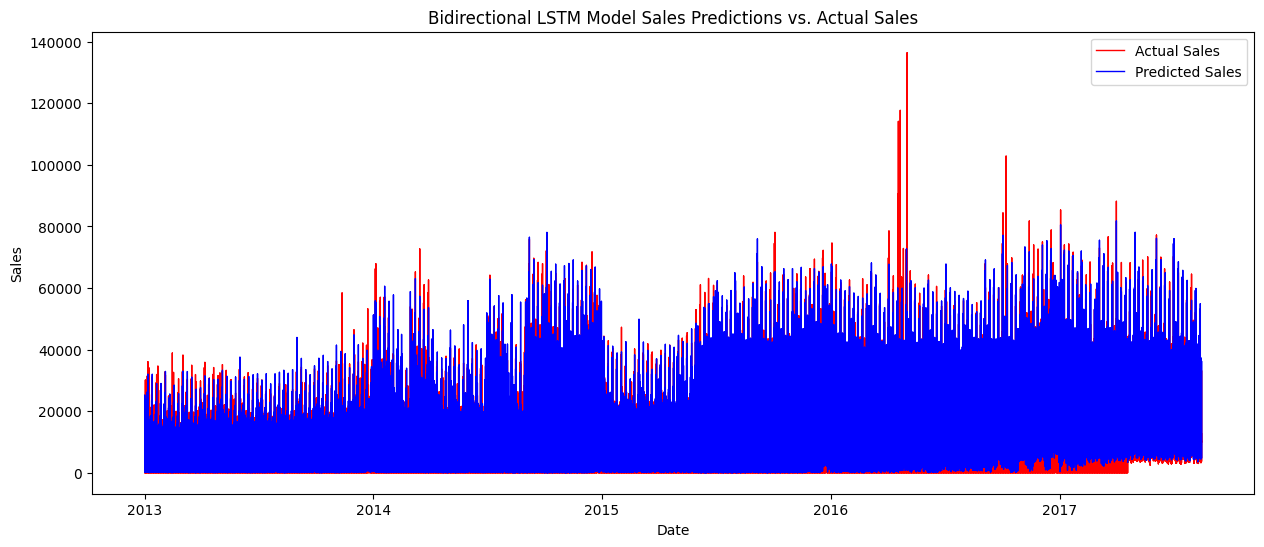

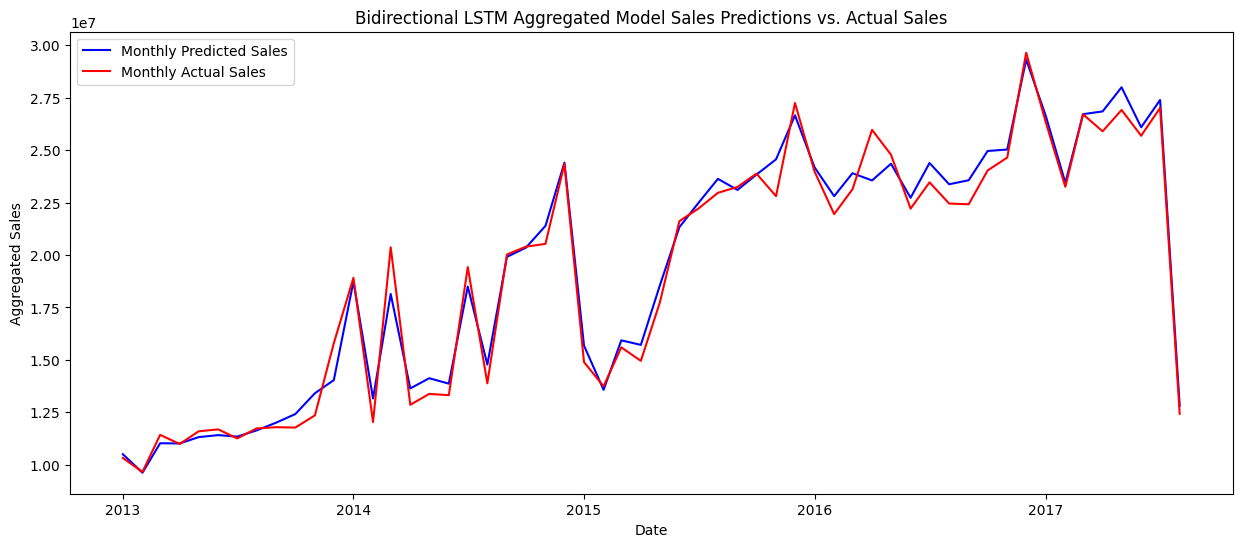

In [ ]:
mae = mean_absolute_error(bilstm_predicted_train_vals_rescaled, y_train_rescaled)
print(f"MAE on Rescaled Training Data: {mae}")

mse = math.sqrt(mean_squared_error(bilstm_predicted_train_vals_rescaled, y_train_rescaled))
print(f"RMSE on Rescaled Training Data: {mse}")

bilstm_total_predicted_sales = np.sum(bilstm_predicted_train_vals_rescaled, axis=1)

total_actual_sales = np.sum(y_train_rescaled, axis=1)

bilstm_pred_df_copy = cleaned_train_data.drop(columns=cleaned_train_data.columns.difference(['date']))

bilstm_pred_df_copy['predicted_sales'] = bilstm_total_predicted_sales

actual_df_copy = cleaned_train_data.drop(columns=cleaned_train_data.columns.difference(['date']))

actual_df_copy['actual_sales'] = total_actual_sales


plotter.figure(figsize=(15, 6))
plotter.plot(actual_df_copy['date'], actual_df_copy['actual_sales'], label='Actual Sales', color='red', linewidth=1)
plotter.plot(bilstm_pred_df_copy['date'], bilstm_pred_df_copy['predicted_sales'], label='Predicted Sales', color='blue', linewidth=1)
plotter.title("Bidirectional LSTM Model Sales Predictions vs. Actual Sales")
plotter.xlabel("Date")
plotter.ylabel("Sales")
plotter.legend()
plotter.show()

bilstm_pred_df_copy['month'] = bilstm_pred_df_copy['date'].dt.to_period('M')
bilstm_monthly_pred = bilstm_pred_df_copy.groupby('month')['predicted_sales'].sum()
actual_df_copy['month'] = actual_df_copy['date'].dt.to_period('M')
monthly_actual = actual_df_copy.groupby('month')['actual_sales'].sum()

plotter.figure(figsize=(15, 6))
plotter.plot(bilstm_monthly_pred.index.to_timestamp(), bilstm_monthly_pred, 'b-', label='Monthly Predicted Sales')
plotter.plot(monthly_actual.index.to_timestamp(), monthly_actual, 'r-', label='Monthly Actual Sales')
plotter.title("Bidirectional LSTM Aggregated Model Sales Predictions vs. Actual Sales")
plotter.xlabel("Date")
plotter.ylabel("Aggregated Sales")
plotter.legend()
plotter.show()

#Basic LSTM Model

In [ ]:
lstm_model = Sequential([
    LSTM(75, return_sequences=True, input_shape=(scaled_X_train.shape[1], scaled_X_train.shape[2])),
    TimeDistributed(Dense(33))
])

lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

if os.path.exists('lstm_model.keras'):
    lstm_model = load_model('lstm_model.keras')
else:
  lstm_model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stop])

In [ ]:
lstm_model.save('lstm_model.keras')

In [ ]:
predicted_vals = lstm_model.predict(scaled_X_train)

lstm_predicted_train_vals_rescaled = y_data_scaler.inverse_transform(predicted_vals.reshape(-1, predicted_vals.shape[-1]))

lstm_predicted_train_vals_rescaled[lstm_predicted_train_vals_rescaled < 0] = 0

y_train_rescaled = y_data_scaler.inverse_transform(scaled_Y_train.reshape(-1, scaled_Y_train.shape[-1]))

53/53 [==============================] - 1s 26ms/step


MAE on Rescaled Training Data: 65.6011627012367
RMSE on Rescaled Training Data: 273.6142880450016


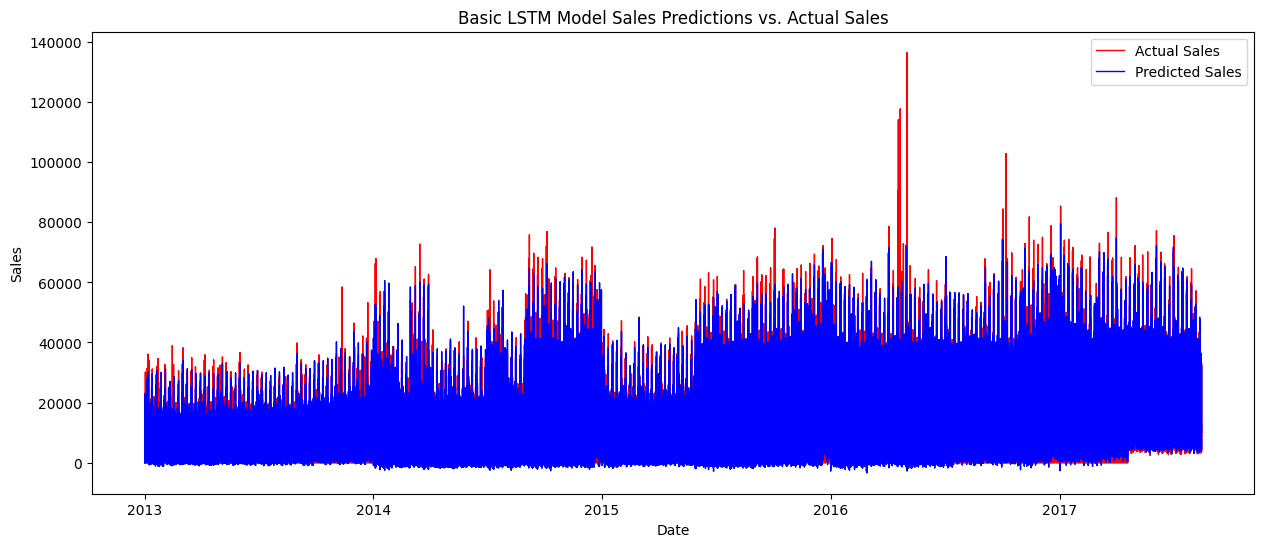

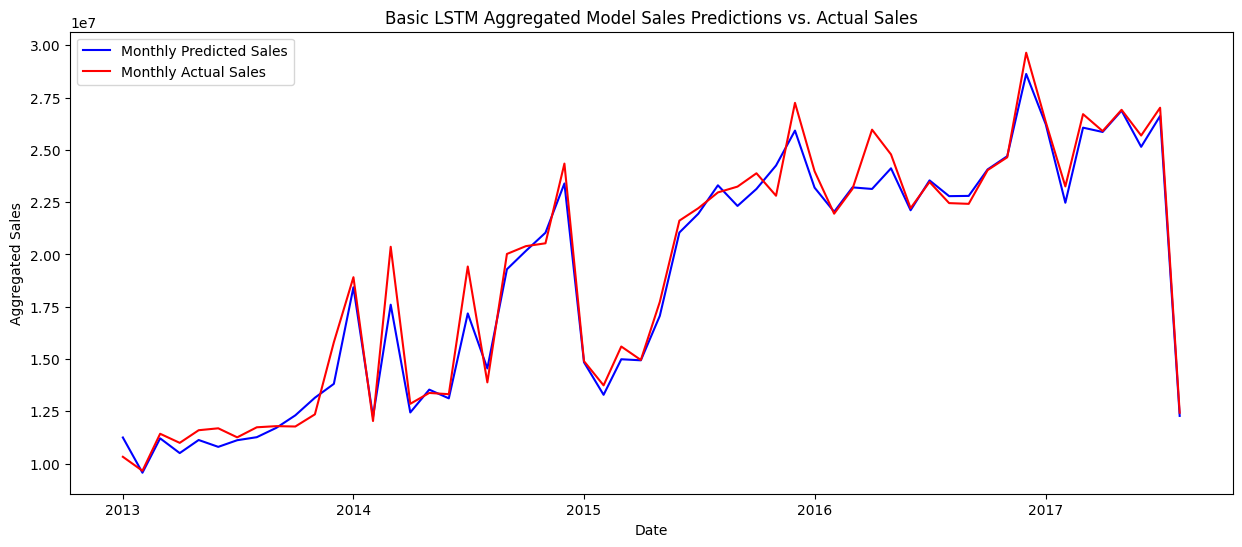

In [ ]:
mae = mean_absolute_error(lstm_predicted_train_vals_rescaled, y_train_rescaled)
print(f"MAE on Rescaled Training Data: {mae}")

mse = math.sqrt(mean_squared_error(lstm_predicted_train_vals_rescaled, y_train_rescaled))
print(f"RMSE on Rescaled Training Data: {mse}")

lstm_total_predicted_sales = np.sum(lstm_predicted_train_vals_rescaled, axis=1)

total_actual_sales = np.sum(y_train_rescaled, axis=1)

lstm_pred_df_copy = cleaned_train_data.drop(columns=cleaned_train_data.columns.difference(['date']))

lstm_pred_df_copy['predicted_sales'] = lstm_total_predicted_sales

actual_df_copy = cleaned_train_data.drop(columns=cleaned_train_data.columns.difference(['date']))

actual_df_copy['actual_sales'] = total_actual_sales


plotter.figure(figsize=(15, 6))
plotter.plot(actual_df_copy['date'], actual_df_copy['actual_sales'], label='Actual Sales', color='red', linewidth=1)
plotter.plot(lstm_pred_df_copy['date'], lstm_pred_df_copy['predicted_sales'], label='Predicted Sales', color='blue', linewidth=1)
plotter.title("Basic LSTM Model Sales Predictions vs. Actual Sales")
plotter.xlabel("Date")
plotter.ylabel("Sales")
plotter.legend()
plotter.show()

lstm_pred_df_copy['month'] = lstm_pred_df_copy['date'].dt.to_period('M')
lstm_monthly_pred = lstm_pred_df_copy.groupby('month')['predicted_sales'].sum()
actual_df_copy['month'] = actual_df_copy['date'].dt.to_period('M')
monthly_actual = actual_df_copy.groupby('month')['actual_sales'].sum()

plotter.figure(figsize=(15, 6))
plotter.plot(lstm_monthly_pred.index.to_timestamp(), lstm_monthly_pred, 'b-', label='Monthly Predicted Sales')
plotter.plot(monthly_actual.index.to_timestamp(), monthly_actual, 'r-', label='Monthly Actual Sales')
plotter.title("Basic LSTM Aggregated Model Sales Predictions vs. Actual Sales")
plotter.xlabel("Date")
plotter.ylabel("Aggregated Sales")
plotter.legend()
plotter.show()

#GRU Model

In [ ]:
gru_model = Sequential([
    GRU(50, return_sequences=True, input_shape=(scaled_X_train.shape[1], scaled_X_train.shape[2])),
    TimeDistributed(Dense(33))
])

gru_model.compile(optimizer='adam', loss='mse')

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

if os.path.exists('gru_model.keras'):
  gru_model = load_model('gru_model.keras')
else:
  gru_model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stop])

In [ ]:
gru_model.save('gru_model.keras')

In [ ]:
predicted_vals = gru_model.predict(scaled_X_train)

gru_predicted_train_vals_rescaled = y_data_scaler.inverse_transform(predicted_vals.reshape(-1, predicted_vals.shape[-1]))

gru_predicted_train_vals_rescaled[gru_predicted_train_vals_rescaled < 0] = 0

y_train_rescaled = y_data_scaler.inverse_transform(scaled_Y_train.reshape(-1, scaled_Y_train.shape[-1]))

53/53 [==============================] - 3s 17ms/step


MAE on Rescaled Training Data: 73.63281187950275
RMSE on Rescaled Training Data: 295.79467284566084


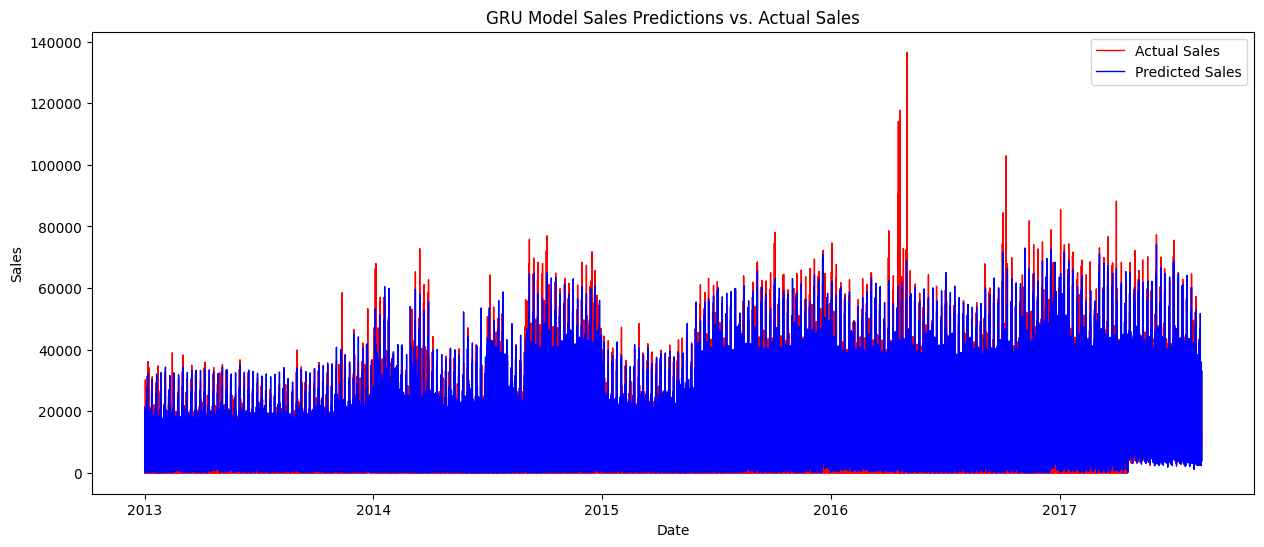

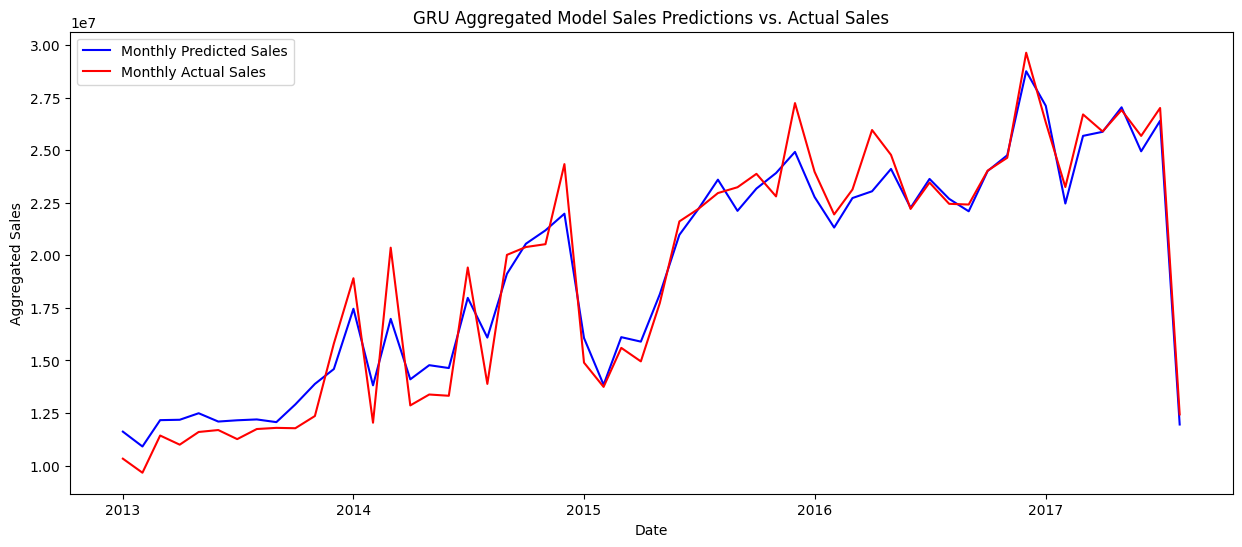

In [ ]:
mae = mean_absolute_error(gru_predicted_train_vals_rescaled, y_train_rescaled)
print(f"MAE on Rescaled Training Data: {mae}")

mse = math.sqrt(mean_squared_error(gru_predicted_train_vals_rescaled, y_train_rescaled))
print(f"RMSE on Rescaled Training Data: {mse}")

gru_total_predicted_sales = np.sum(gru_predicted_train_vals_rescaled, axis=1)

total_actual_sales = np.sum(y_train_rescaled, axis=1)

gru_pred_df_copy = cleaned_train_data.drop(columns=cleaned_train_data.columns.difference(['date']))

gru_pred_df_copy['predicted_sales'] = gru_total_predicted_sales

actual_df_copy = cleaned_train_data.drop(columns=cleaned_train_data.columns.difference(['date']))

actual_df_copy['actual_sales'] = total_actual_sales


plotter.figure(figsize=(15, 6))
plotter.plot(actual_df_copy['date'], actual_df_copy['actual_sales'], label='Actual Sales', color='red', linewidth=1)
plotter.plot(gru_pred_df_copy['date'], gru_pred_df_copy['predicted_sales'], label='Predicted Sales', color='blue', linewidth=1)
plotter.title("GRU Model Sales Predictions vs. Actual Sales")
plotter.xlabel("Date")
plotter.ylabel("Sales")
plotter.legend()
plotter.show()

gru_pred_df_copy['month'] = gru_pred_df_copy['date'].dt.to_period('M')
gru_monthly_pred = gru_pred_df_copy.groupby('month')['predicted_sales'].sum()
actual_df_copy['month'] = actual_df_copy['date'].dt.to_period('M')
monthly_actual = actual_df_copy.groupby('month')['actual_sales'].sum()

plotter.figure(figsize=(15, 6))
plotter.plot(gru_monthly_pred.index.to_timestamp(), gru_monthly_pred, 'b-', label='Monthly Predicted Sales')
plotter.plot(monthly_actual.index.to_timestamp(), monthly_actual, 'r-', label='Monthly Actual Sales')
plotter.title("GRU Aggregated Model Sales Predictions vs. Actual Sales")
plotter.xlabel("Date")
plotter.ylabel("Aggregated Sales")
plotter.legend()
plotter.show()

#Hybrid CNN-LSTM Model (Proposed Model)

In [ ]:
if os.path.exists('cnn_lstm_model-BEST.keras'):
    cnn_lstm_model = load_model('cnn_lstm_model-BEST.keras')

    predicted_vals = cnn_lstm_model.predict(scaled_X_train)

    hybrid_predicted_train_vals_rescaled = y_data_scaler.inverse_transform(predicted_vals.reshape(-1, predicted_vals.shape[-1]))

    hybrid_predicted_train_vals_rescaled[hybrid_predicted_train_vals_rescaled < 0] = 0

    y_train_rescaled = y_data_scaler.inverse_transform(scaled_Y_train.reshape(-1, scaled_Y_train.shape[-1]))

else:
  print("MODEL FILE MISSING. CANNOT PREDICT.")

53/53 [==============================] - 2s 30ms/step


MAE on Rescaled Training Data: 60.46432223959423
RMSE on Rescaled Training Data: 266.12087330671466


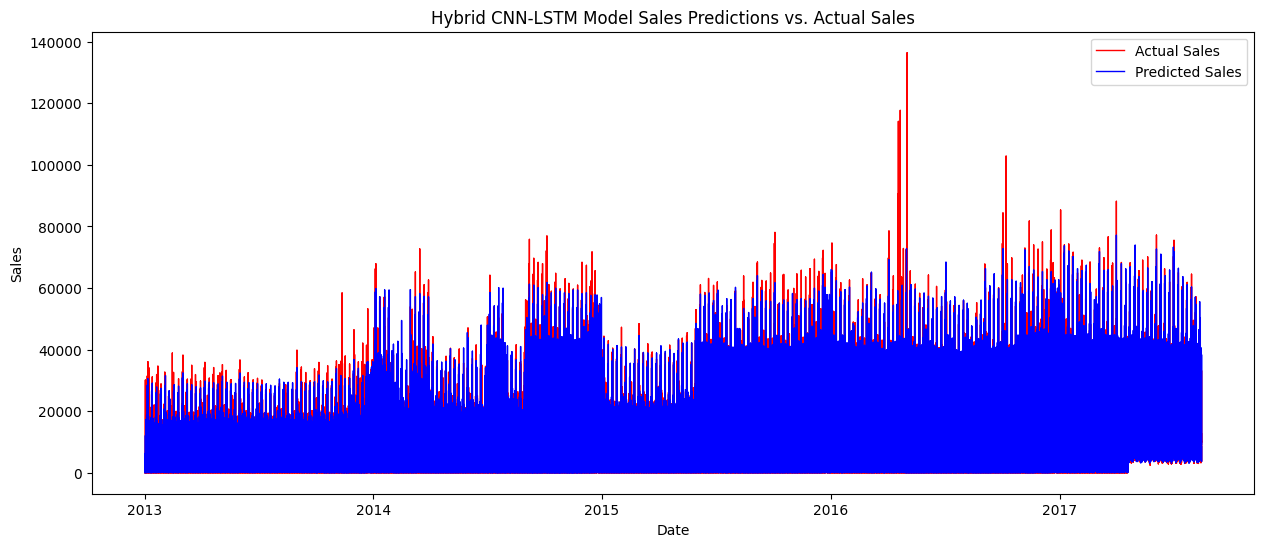

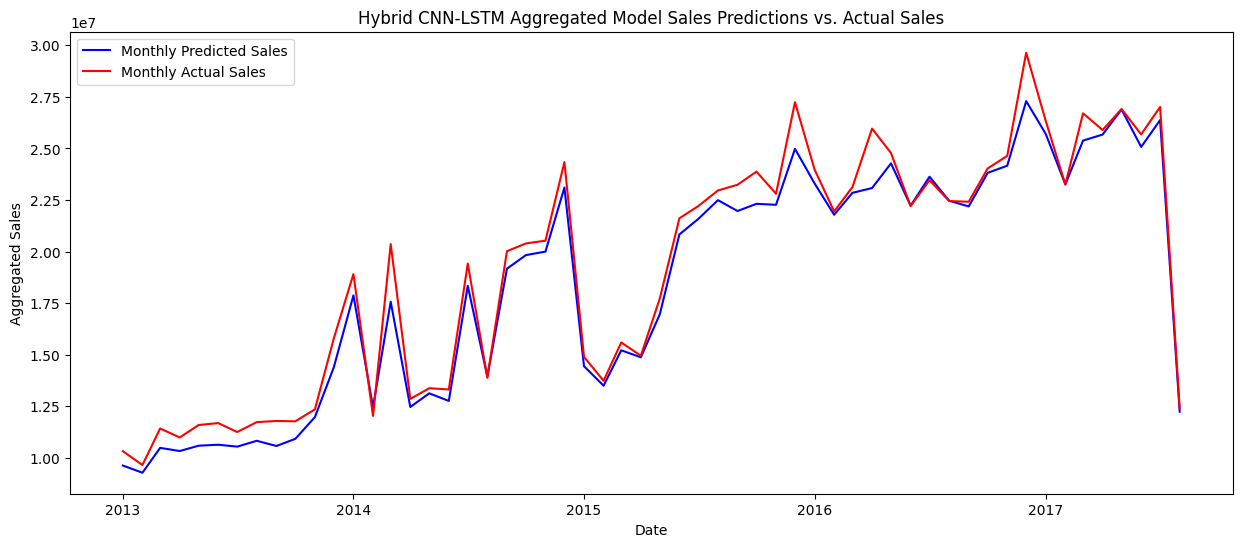

In [ ]:
mae = mean_absolute_error(hybrid_predicted_train_vals_rescaled, y_train_rescaled)
print(f"MAE on Rescaled Training Data: {mae}")

mse = math.sqrt(mean_squared_error(hybrid_predicted_train_vals_rescaled, y_train_rescaled))
print(f"RMSE on Rescaled Training Data: {mse}")

hybrid_total_predicted_sales = np.sum(hybrid_predicted_train_vals_rescaled, axis=1)

total_actual_sales = np.sum(y_train_rescaled, axis=1)

hybrid_pred_df_copy = cleaned_train_data.drop(columns=cleaned_train_data.columns.difference(['date']))

hybrid_pred_df_copy['predicted_sales'] = hybrid_total_predicted_sales

actual_df_copy = cleaned_train_data.drop(columns=cleaned_train_data.columns.difference(['date']))

actual_df_copy['actual_sales'] = total_actual_sales


plotter.figure(figsize=(15, 6))
plotter.plot(actual_df_copy['date'], actual_df_copy['actual_sales'], label='Actual Sales', color='red', linewidth=1)
plotter.plot(hybrid_pred_df_copy['date'], hybrid_pred_df_copy['predicted_sales'], label='Predicted Sales', color='blue', linewidth=1)
plotter.title("Hybrid CNN-LSTM Model Sales Predictions vs. Actual Sales")
plotter.xlabel("Date")
plotter.ylabel("Sales")
plotter.legend()
plotter.show()

hybrid_pred_df_copy['month'] = hybrid_pred_df_copy['date'].dt.to_period('M')
hybrid_monthly_pred = hybrid_pred_df_copy.groupby('month')['predicted_sales'].sum()
actual_df_copy['month'] = actual_df_copy['date'].dt.to_period('M')
monthly_actual = actual_df_copy.groupby('month')['actual_sales'].sum()

plotter.figure(figsize=(15, 6))
plotter.plot(hybrid_monthly_pred.index.to_timestamp(), hybrid_monthly_pred, 'b-', label='Monthly Predicted Sales')
plotter.plot(monthly_actual.index.to_timestamp(), monthly_actual, 'r-', label='Monthly Actual Sales')
plotter.title("Hybrid CNN-LSTM Aggregated Model Sales Predictions vs. Actual Sales")
plotter.xlabel("Date")
plotter.ylabel("Aggregated Sales")
plotter.legend()
plotter.show()

#All Models Charted Together Aggregated Monthly

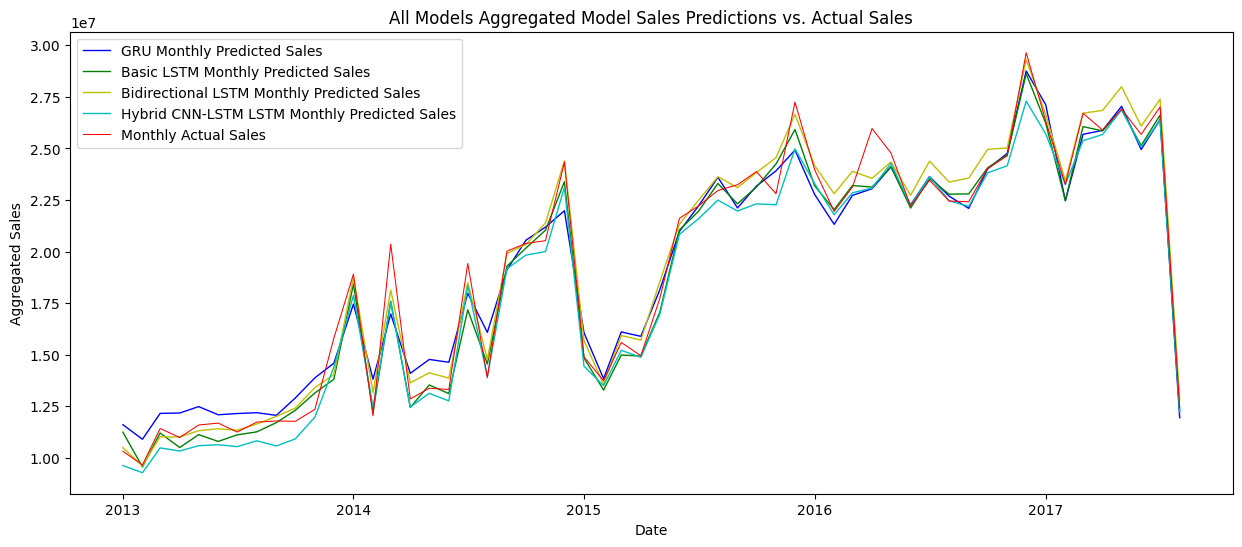

In [ ]:
plotter.figure(figsize=(15, 6))
plotter.plot(gru_monthly_pred.index.to_timestamp(), gru_monthly_pred, 'b-', label='GRU Monthly Predicted Sales', linewidth=1)
plotter.plot(lstm_monthly_pred.index.to_timestamp(), lstm_monthly_pred, 'g-', label='Basic LSTM Monthly Predicted Sales', linewidth=1)
plotter.plot(bilstm_monthly_pred.index.to_timestamp(), bilstm_monthly_pred, 'y-', label='Bidirectional LSTM Monthly Predicted Sales', linewidth=1)
plotter.plot(hybrid_monthly_pred.index.to_timestamp(), hybrid_monthly_pred, 'c-', label='Hybrid CNN-LSTM LSTM Monthly Predicted Sales', linewidth=1)
plotter.plot(monthly_actual.index.to_timestamp(), monthly_actual, 'r-', label='Monthly Actual Sales', linewidth=0.75)
plotter.title("All Models Aggregated Model Sales Predictions vs. Actual Sales")
plotter.xlabel("Date")
plotter.ylabel("Aggregated Sales")
plotter.legend()
plotter.show()